<a href="https://colab.research.google.com/github/Dopamine-Max/CNN-Milestone-projects/blob/main/Style_Transfer_Vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #5 CNN MILESTONE PROJECT
## Using Vgg19 for Style Transfer operation
####Using the pretrained Vgg19 to transfer the style of one image onto another image

In [79]:
# import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from imageio import imread

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-79-e6c2fb13b8ba>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [80]:
# import the model then send to gpu
vgg19net = torchvision.models.vgg19(pretrained=True)

#freeze the layers
for p in vgg19net.parameters():
  p.requires_grad = False

#set to evaluation mode
vgg19net.eval()

#send network to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vgg19net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [81]:
# import the two images, transform and display them

img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
img4style   = imread('https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg')

#initialize the target image as a blank canvas of random noise
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256), #the images might be really large so we resize them to reduce the training time
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) #Default Normalization parameters for AlexNet
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device) #Returns a new tensor with a dimension of size one inserted at the specified position.
img4style   = Ts( img4style ).unsqueeze(0).to(device)
img4target  = Ts( img4target ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

<ipython-input-81-348f4479adc0>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')
<ipython-input-81-348f4479adc0>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style   = imread('https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg')


torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 324])


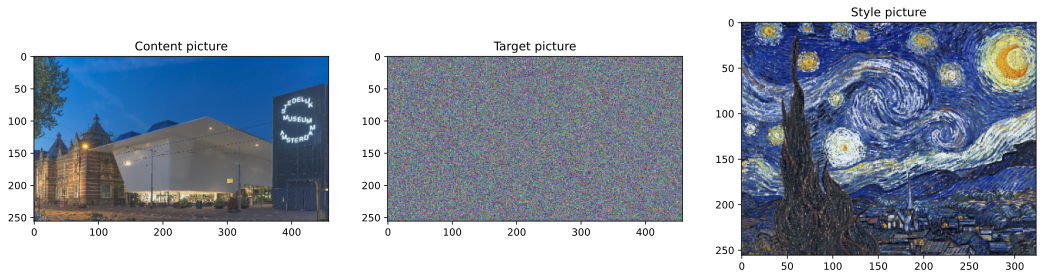

In [82]:
# Inspecting the Intial pics

fig,ax = plt.subplots(1,3,figsize=(18,5))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

In [83]:
# function to return feature maps

def getFeatureMaps(img,net):

  featuremaps = []
  featurenames = []
  convLayeridx = 0

  #loop through all layers in the "features" block
  for layernum in range(len(net.features)):

    #process the image through the layer
    img = net.features[layernum](img)

    #store the image if its a conv2d convolution layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append(img)
      featurenames.append('ConvLayer_' + str(convLayeridx))
      convLayeridx += 1

  return featuremaps,featurenames


In [84]:
# function to return the gram matrix of the feature map

def gramMatrix(M):

  #reshape to 2d
  _,chans,height,width = M.shape
  M = M.reshape(chans,height*width)

  #compute and return the gram matrix
  gram = torch.mm(M,M.t())/(chans*height*width)

  return gram

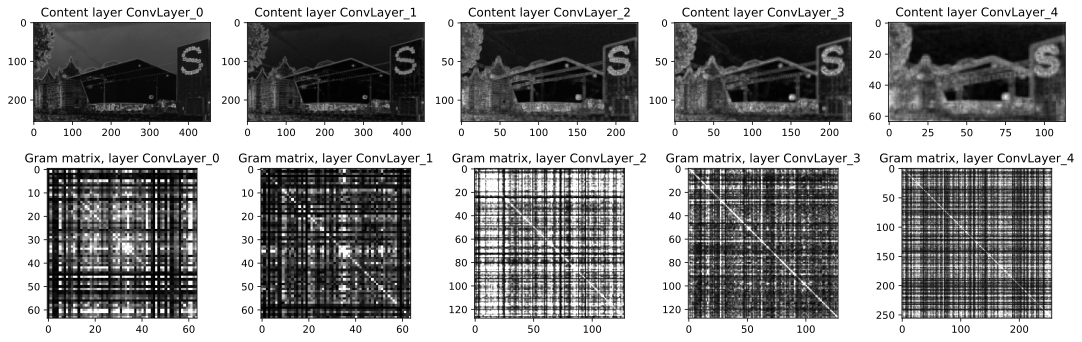

In [85]:
# Inspecting the "content" maps

contentFeatureMaps,contentFeatureNames = getFeatureMaps(img4content,vgg19net)

fig,axs = plt.subplots(2,5,figsize=(15,5))

for i in range(5):

  #average over all the feature maps in i layer and then normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  #display the images
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))

  #do the same for the gram Matrix
  pic = gramMatrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  #display the gram matrices
  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

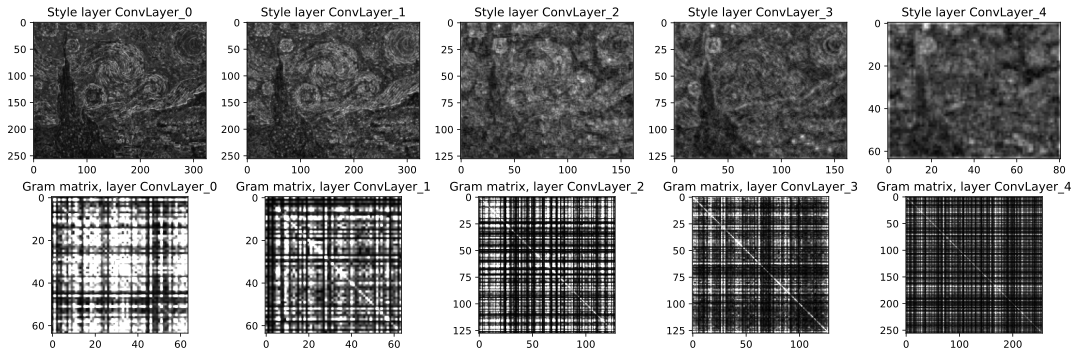

In [86]:
# repeat for the "style" image

styleFeatureMaps,styleFeatureNames = getFeatureMaps(img4style,vgg19net)

fig,axs = plt.subplots(2,5,figsize=(15,5))

for i in range(5):

  #average over all the feature maps in i layer and then normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  #display the images
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))


  #do the same for the gram Matrix
  pic = gramMatrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  #display the gram matrices
  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

In [90]:
# style transfer

#which layers to use
layers4content = [ 'ConvLayer_0','ConvLayer_4']
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4' ]
weights4style  = [      1       ,      .4      ,     .4     ,    .2      ,      .1      ]

#make a copy of the target image and push to GPU
target = img4content.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e8 #arbitary parameter determining impact of style on target

#number of epochs to train
epochs = 1500

#optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005) #RMS prop is recommended for Style Transfer

for epochi in range(epochs):

  #extract the target feature maps
  targetFeatureMaps, targetFeatureNames = getFeatureMaps(target,vgg19net)

  #require losses for backprop
  styleLoss = 0
  contentLoss = 0

  #loop over layers
  for layeri in range(len(targetFeatureNames)):

    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 ) #MSELoss

    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gramMatrix(targetFeatureMaps[layeri])
      Gstyle  = gramMatrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean((Gtarget-Gstyle)**2) * weights4style[layers4style.index(targetFeatureNames[layeri])] #MSELoss

  #combined Loss
  combiLoss = (styleScaling * styleLoss) + contentLoss

  #back propogation
  optimizer.zero_grad()
  combiLoss.backward()
  optimizer.step()


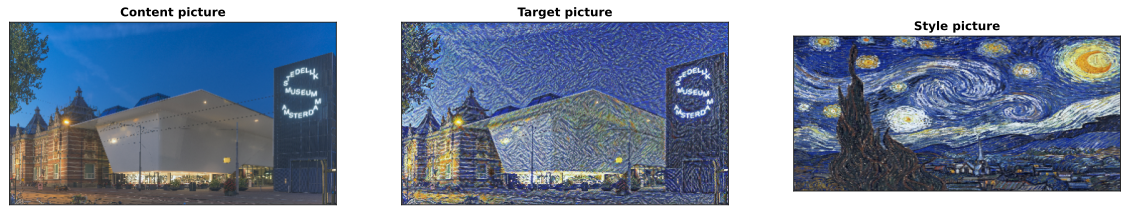

In [91]:
# the final pic

fig,ax = plt.subplots(1,3,figsize=(20,7))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

# save the comparison
# fig.savefig("file1.png")

[]

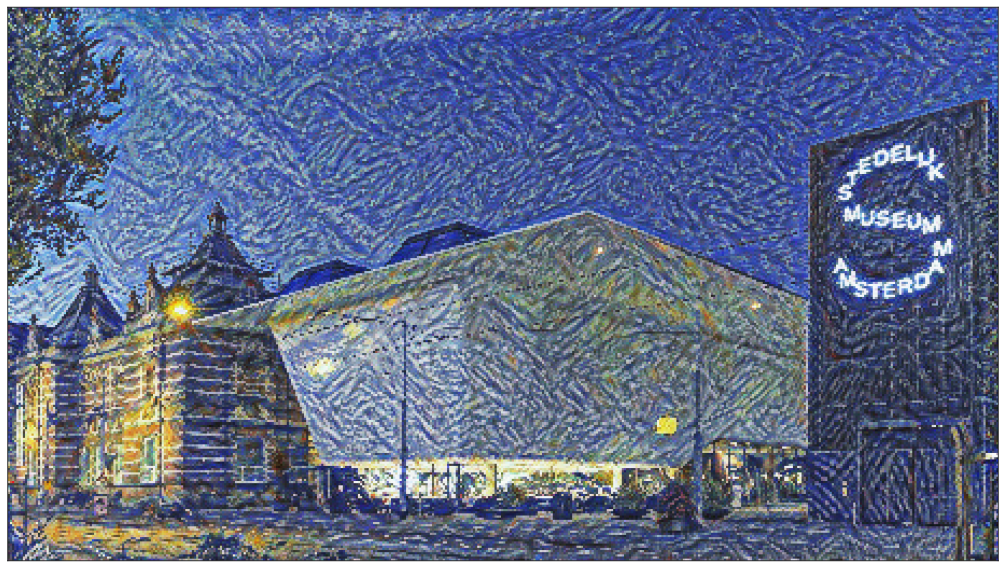

In [92]:
#save the target image

fig,ax = plt.subplots(1,1,figsize=(20,10))
pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax.imshow(pic)
ax.set_xticks([])
ax.set_yticks([])
# fig.savefig("file.png")